In [ ]:
# !pip install -q pytorch-lightning==2.2.4 timm albumentations==1.4.7


In [2]:

# ——————————————————— CONFIG ——————————————————— #
from pathlib import Path

CSV_PATH   = Path("/kaggle/input/greenchoicedata/df_filtered_unique_complete_qtygrams.csv")
IMG_DIR    = Path("/kaggle/input/greenchoiceimages")
OUTPUT_DIR = Path("/kaggle/working")          # artefacts land here
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

RANDOM_SEED   = 42
SAMPLE_FRAC   = 0.40      # **40 % of the dataset for this first run**
IMG_SIZE      = 224
BATCH_SIZE    = 32
EPOCHS        = 12
BASE_LR       = 3e-4
PRIORITY_WEIGHTS = {
    "environmental_score_grade": 2.0,
    "packaging_en": 2.0,
}


In [3]:

# ——————————————————— LIBRARIES ——————————————————— #
import os, random, json, pickle
import numpy as np, pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm.auto import tqdm


In [4]:
# Reproducibility
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED); torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ——————————————————— DATA LOADING ——————————————————— #
print("Loading CSV …")
df = pd.read_csv(CSV_PATH)
print(f"Rows in CSV: {len(df):,}")

# Use only 40 % for this first experiment (stratified later) — keep sample before dropping missing images
if SAMPLE_FRAC < 1.0:
    df = df.sample(frac=SAMPLE_FRAC, random_state=RANDOM_SEED).reset_index(drop=True)
    print(f"Subset rows (40 %): {len(df):,}")

# Build absolute image path
IMG_EXT = ".jpg"
df["image_path"] = df["code"].astype(str).str.strip() + IMG_EXT

mask_exists = df["image_path"].apply(lambda p: (IMG_DIR / p).is_file())
missing = (~mask_exists).sum()
if missing:
    print(f"⚠️  {missing:,} rows dropped — image not found")
df = df[mask_exists].reset_index(drop=True)
print(f"Rows after dropping missing images: {len(df):,}")

# ————————————— TARGET DEFINITIONS ————————————— #
SINGLE_LABEL_COLS = [
    "environmental_score_grade",
    "main_category_en",
    "nutriscore_grade",
]
MULTI_LABEL_COLS = [
    "packaging_en",
    "labels_en",
]
TARGET_COLS = SINGLE_LABEL_COLS + MULTI_LABEL_COLS



Loading CSV …
Rows in CSV: 100,606
Subset rows (40 %): 40,242
⚠️  2 rows dropped — image not found
Rows after dropping missing images: 40,240


In [5]:

# ————————————— ENCODING ————————————— #
label_encoders: dict[str, LabelEncoder] = {}
multi_encoders: dict[str, MultiLabelBinarizer] = {}

# single‑label → integers
for col in SINGLE_LABEL_COLS:
    le = LabelEncoder(); df[col] = le.fit_transform(df[col].astype(str)); label_encoders[col] = le

# multi‑label → one‑hot vectors
for col in MULTI_LABEL_COLS:
    mlb = MultiLabelBinarizer()
    df[col] = df[col].fillna("").apply(lambda x: [v.strip() for v in str(x).split(',') if v.strip()])
    mlb.fit(df[col]); df[col] = df[col].apply(lambda x: mlb.transform([x])[0].astype(np.float32)); multi_encoders[col] = mlb

# Train/val split (stratify on priority target so both sets keep distribution)
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=RANDOM_SEED,
    stratify=df["environmental_score_grade"],
)
print(f"Train: {len(train_df):,} · Val: {len(val_df):,}")

# ——————————————————— DATASET & LOADER ——————————————————— #
class GreenChoiceDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, transform, img_dir: Path):
        self.df, self.tfm, self.img_dir = dataframe.reset_index(drop=True), transform, img_dir
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img = Image.open(self.img_dir / row["image_path"]).convert("RGB")
        img = self.tfm(img)
        tgt = {
            "environmental_score_grade": torch.tensor(row["environmental_score_grade"], dtype=torch.long),
            "main_category_en":        torch.tensor(row["main_category_en"], dtype=torch.long),
            "nutriscore_grade":        torch.tensor(row["nutriscore_grade"], dtype=torch.long),
            "packaging_en":            torch.tensor(row["packaging_en"], dtype=torch.float32),
            "labels_en":               torch.tensor(row["labels_en"], dtype=torch.float32),
        }
        return img, tgt

transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_loader = DataLoader(GreenChoiceDataset(train_df, transform_train, IMG_DIR),
                          batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(GreenChoiceDataset(val_df,   transform_val,   IMG_DIR),
                          batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


Train: 32,192 · Val: 8,048


In [6]:
# ───────────────────── IMPORTS ───────────────────── #
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score

# Enable CuDNN auto‑tuner for speed when input size is constant
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

# (Assumes SINGLE_LABEL_COLS, MULTI_LABEL_COLS, label_encoders, multi_encoders,
#  train_loader, val_loader, EPOCHS, BASE_LR, IMG_SIZE, IMG_DIR, OUTPUT_DIR)


# ───────────────────── DEVICE ───────────────────── #
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ───────────────────── PRIORITY WEIGHTS ───────────────────── #
PRIORITY_WEIGHTS = {
    "environmental_score_grade": 2.0,
    "packaging_en": 2.0,
}


# ───────────────────── MODEL DEFINITION ───────────────────── #
class MultiTaskHead(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc(x)


class MultiTaskModel(nn.Module):
    def __init__(self, num_cls_single: dict[str, int], num_cls_multi: dict[str, int]):
        super().__init__()
        backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        in_feats = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()
        self.backbone = backbone
        self.heads = nn.ModuleDict({
            k: MultiTaskHead(in_feats, n) for k, n in {**num_cls_single, **num_cls_multi}.items()
        })

    def forward(self, x: torch.Tensor) -> dict[str, torch.Tensor]:
        feats = self.backbone(x)
        return {k: head(feats) for k, head in self.heads.items()}


# ───────────────────── INSTANTIATE MODEL ───────────────────── #
num_classes_single = {c: len(label_encoders[c].classes_) for c in SINGLE_LABEL_COLS}
num_classes_multi = {c: len(multi_encoders[c].classes_) for c in MULTI_LABEL_COLS}
model = MultiTaskModel(num_classes_single, num_classes_multi).to(DEVICE)


# ───────────────────── LOSS & OPTIMISER ───────────────────── #
criterions = {
    **{c: nn.CrossEntropyLoss() for c in SINGLE_LABEL_COLS},
    **{c: nn.BCEWithLogitsLoss() for c in MULTI_LABEL_COLS},
}

optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Mixed‑precision utilities
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


# ───────────────────── UTILITIES ───────────────────── #

def compute_loss(outputs: dict[str, torch.Tensor], targets: dict[str, torch.Tensor]) -> torch.Tensor:
    loss = 0.0
    for k, logits in outputs.items():
        w = PRIORITY_WEIGHTS.get(k, 1.0)
        loss += w * criterions[k](logits, targets[k])
    return loss


def accumulate_metrics(store: dict, outs: dict[str, torch.Tensor], tgts: dict[str, torch.Tensor]):
    for k, logits in outs.items():
        if k not in store:
            store[k] = {"preds": [], "trues": []}
        if k in SINGLE_LABEL_COLS:
            store[k]["preds"].extend(logits.argmax(1).cpu().tolist())
            store[k]["trues"].extend(tgts[k].cpu().tolist())
        else:
            store[k]["preds"].extend((logits.sigmoid() > 0.5).int().cpu().tolist())
            store[k]["trues"].extend(tgts[k].int().cpu().tolist())



Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 141MB/s]
/tmp/ipykernel_35/727511420.py:71: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [7]:

# ───────────────────── EPOCH FUNCTIONS ───────────────────── #

def run_epoch(model: nn.Module, loader: DataLoader, train: bool = True, collect_metrics: bool = True):
    if train:
        model.train()
    else:
        model.eval()
    running_loss = 0.0
    metrics: dict[str, dict[str, list]] = {}

    with torch.set_grad_enabled(train):
        for imgs, tgts in tqdm(loader, leave=False, desc="train" if train else "val"):
            imgs = imgs.to(DEVICE, non_blocking=True)
            tgts = {k: v.to(DEVICE, non_blocking=True) for k, v in tgts.items()}

            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                outs = model(imgs)
                loss = compute_loss(outs, tgts)

            if train:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            running_loss += loss.item() * imgs.size(0)
            if collect_metrics:
                accumulate_metrics(metrics, outs, tgts)

    if train:
        scheduler.step()

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss, metrics


# ───────────────────── TRAINING LOOP ───────────────────── #
best_combo_score = 0.0  # env‑acc + packaging‑f1
history = defaultdict(list)

for epoch in range(1, EPOCHS + 1):
    # ---- TRAIN ----
    train_loss, _ = run_epoch(model, train_loader, train=True, collect_metrics=False)  # skip metrics for speed
    history["train_loss"].append(train_loss)
    print(f"\nEpoch {epoch:02}/{EPOCHS} — Train Loss: {train_loss:.4f}")

    # ---- SEPARATOR ----
    print("----")

    # ---- VAL ----
    val_loss, val_metrics = run_epoch(model, val_loader, train=False, collect_metrics=True)
    history["val_loss"].append(val_loss)
    print(f"Val   Loss: {val_loss:.4f}")

    env_val_acc = None
    pack_val_f1 = None

    for k, d in val_metrics.items():
        if k in SINGLE_LABEL_COLS:
            score = accuracy_score(d["trues"], d["preds"])
            metric_name = "acc"
        else:
            score = f1_score(d["trues"], d["preds"], average="micro", zero_division=0)
            metric_name = "f1"
        history[f"val_{k}_{metric_name}"].append(score)
        print(f"  [val]  {k:<26} {metric_name.upper()}: {score:.4f}")

        if k == "environmental_score_grade":
            env_val_acc = score
        if k == "packaging_en":
            pack_val_f1 = score

    # ---- MODEL CHECKPOINTING ----
    if env_val_acc is not None and pack_val_f1 is not None:
        combo_score = env_val_acc + pack_val_f1
        if combo_score > best_combo_score:
            best_combo_score = combo_score
            torch.save(model.state_dict(), OUTPUT_DIR / "best_model.pt")
            print(f"   ✓ New best model saved (combo {combo_score:.4f})")

print(f"\nTraining complete — best combo (env‑acc + pack‑f1): {best_combo_score:.4f}")
# ───────────────────────── END ───────────────────────── #


train:   0%|          | 0/1006 [00:00<?, ?it/s]

/tmp/ipykernel_35/816931150.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



Epoch 01/12 — Train Loss: 12.3290
----


val:   0%|          | 0/252 [00:00<?, ?it/s]

Val   Loss: 11.1114
  [val]  environmental_score_grade  ACC: 0.3228
  [val]  main_category_en           ACC: 0.1240
  [val]  nutriscore_grade           ACC: 0.4319
  [val]  packaging_en               F1: 0.2099
  [val]  labels_en                  F1: 0.1222
   ✓ New best model saved (combo 0.5327)


train:   0%|          | 0/1006 [00:00<?, ?it/s]

/tmp/ipykernel_35/816931150.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



Epoch 02/12 — Train Loss: 9.9238
----


val:   0%|          | 0/252 [00:00<?, ?it/s]

Val   Loss: 10.5268
  [val]  environmental_score_grade  ACC: 0.3497
  [val]  main_category_en           ACC: 0.1700
  [val]  nutriscore_grade           ACC: 0.4556
  [val]  packaging_en               F1: 0.3009
  [val]  labels_en                  F1: 0.2229
   ✓ New best model saved (combo 0.6505)


train:   0%|          | 0/1006 [00:00<?, ?it/s]

/tmp/ipykernel_35/816931150.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



Epoch 03/12 — Train Loss: 8.5139
----


val:   0%|          | 0/252 [00:00<?, ?it/s]

Val   Loss: 10.1808
  [val]  environmental_score_grade  ACC: 0.3749
  [val]  main_category_en           ACC: 0.1942
  [val]  nutriscore_grade           ACC: 0.4737
  [val]  packaging_en               F1: 0.3419
  [val]  labels_en                  F1: 0.2516
   ✓ New best model saved (combo 0.7167)


train:   0%|          | 0/1006 [00:00<?, ?it/s]

/tmp/ipykernel_35/816931150.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



Epoch 04/12 — Train Loss: 7.3351
----


val:   0%|          | 0/252 [00:00<?, ?it/s]

Val   Loss: 10.1769
  [val]  environmental_score_grade  ACC: 0.3787
  [val]  main_category_en           ACC: 0.2137
  [val]  nutriscore_grade           ACC: 0.4870
  [val]  packaging_en               F1: 0.2927
  [val]  labels_en                  F1: 0.2402


train:   0%|          | 0/1006 [00:00<?, ?it/s]

/tmp/ipykernel_35/816931150.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



Epoch 05/12 — Train Loss: 6.2142
----


val:   0%|          | 0/252 [00:00<?, ?it/s]

Val   Loss: 10.4253
  [val]  environmental_score_grade  ACC: 0.3858
  [val]  main_category_en           ACC: 0.2232
  [val]  nutriscore_grade           ACC: 0.4815
  [val]  packaging_en               F1: 0.3368
  [val]  labels_en                  F1: 0.2813
   ✓ New best model saved (combo 0.7226)


train:   0%|          | 0/1006 [00:00<?, ?it/s]

/tmp/ipykernel_35/816931150.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



Epoch 06/12 — Train Loss: 5.2280
----


val:   0%|          | 0/252 [00:00<?, ?it/s]

Val   Loss: 10.5798
  [val]  environmental_score_grade  ACC: 0.3909
  [val]  main_category_en           ACC: 0.2296
  [val]  nutriscore_grade           ACC: 0.4922
  [val]  packaging_en               F1: 0.3546
  [val]  labels_en                  F1: 0.2835
   ✓ New best model saved (combo 0.7455)


train:   0%|          | 0/1006 [00:00<?, ?it/s]

/tmp/ipykernel_35/816931150.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



Epoch 07/12 — Train Loss: 4.3666
----


val:   0%|          | 0/252 [00:00<?, ?it/s]

Val   Loss: 10.9694
  [val]  environmental_score_grade  ACC: 0.3867
  [val]  main_category_en           ACC: 0.2350
  [val]  nutriscore_grade           ACC: 0.4948
  [val]  packaging_en               F1: 0.3333
  [val]  labels_en                  F1: 0.2862


train:   0%|          | 0/1006 [00:00<?, ?it/s]

/tmp/ipykernel_35/816931150.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



Epoch 08/12 — Train Loss: 3.6899
----


val:   0%|          | 0/252 [00:00<?, ?it/s]

Val   Loss: 11.2902
  [val]  environmental_score_grade  ACC: 0.3869
  [val]  main_category_en           ACC: 0.2320
  [val]  nutriscore_grade           ACC: 0.4960
  [val]  packaging_en               F1: 0.3448
  [val]  labels_en                  F1: 0.2835


train:   0%|          | 0/1006 [00:00<?, ?it/s]

/tmp/ipykernel_35/816931150.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



Epoch 09/12 — Train Loss: 3.1624
----


val:   0%|          | 0/252 [00:00<?, ?it/s]

Val   Loss: 11.6137
  [val]  environmental_score_grade  ACC: 0.3966
  [val]  main_category_en           ACC: 0.2316
  [val]  nutriscore_grade           ACC: 0.4933
  [val]  packaging_en               F1: 0.3530
  [val]  labels_en                  F1: 0.3022
   ✓ New best model saved (combo 0.7496)


train:   0%|          | 0/1006 [00:00<?, ?it/s]

/tmp/ipykernel_35/816931150.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



Epoch 10/12 — Train Loss: 2.7944
----


val:   0%|          | 0/252 [00:00<?, ?it/s]

Val   Loss: 11.7966
  [val]  environmental_score_grade  ACC: 0.3872
  [val]  main_category_en           ACC: 0.2319
  [val]  nutriscore_grade           ACC: 0.4968
  [val]  packaging_en               F1: 0.3528
  [val]  labels_en                  F1: 0.2826


train:   0%|          | 0/1006 [00:00<?, ?it/s]

/tmp/ipykernel_35/816931150.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



Epoch 11/12 — Train Loss: 2.5647
----


val:   0%|          | 0/252 [00:00<?, ?it/s]

Val   Loss: 11.8656
  [val]  environmental_score_grade  ACC: 0.3878
  [val]  main_category_en           ACC: 0.2314
  [val]  nutriscore_grade           ACC: 0.4912
  [val]  packaging_en               F1: 0.3512
  [val]  labels_en                  F1: 0.2919


train:   0%|          | 0/1006 [00:00<?, ?it/s]

/tmp/ipykernel_35/816931150.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



Epoch 12/12 — Train Loss: 2.4541
----


val:   0%|          | 0/252 [00:00<?, ?it/s]

Val   Loss: 11.9865
  [val]  environmental_score_grade  ACC: 0.3842
  [val]  main_category_en           ACC: 0.2329
  [val]  nutriscore_grade           ACC: 0.4929
  [val]  packaging_en               F1: 0.3535
  [val]  labels_en                  F1: 0.2810

Training complete — best combo (env‑acc + pack‑f1): 0.7496


In [8]:
import pickle
import torch

# Save encoders and column configs
with open("encoders.pkl", "wb") as f:
    pickle.dump({
        "label_encoders": label_encoders,
        "multi_encoders": multi_encoders,
        "SINGLE_LABEL_COLS": SINGLE_LABEL_COLS,
        "MULTI_LABEL_COLS": MULTI_LABEL_COLS,
    }, f)

# Save checkpoint with model, optimizer, etc.
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
    "epoch": epoch,
    "history": history,
}, "checkpoint_latest.pt")


In [3]:
# ───────────── GreenChoice — TEST-ONLY SNIPPET (handles unseen labels) ─────────────
# Evaluates best_model.pt on a 10 % test split drawn from data that was
# NOT in the 40 % train+val subset. Rows whose single-label targets were
# unseen during training are dropped, and the script reports how many.

from pathlib import Path
import pickle, random
import numpy as np, pandas as pd
from PIL import Image, ImageFile
from sklearn.metrics import accuracy_score, f1_score
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm.auto import tqdm

# ---------------- Paths & constants ---------------- #
CSV_PATH   = Path("/kaggle/input/greenchoicedata/df_filtered_unique_complete_qtygrams.csv")
IMG_DIR    = Path("/kaggle/input/greenchoiceimages")
MODEL_DIR  = Path("/kaggle/input/greenchoicemodel1/pytorch/default/1")
IMG_EXT    = ".jpg"
RANDOM_SEED = 42
TRAINVAL_FRAC = 0.40     # fraction used for train+val
TEST_FRAC     = 0.10     # evaluate on 10 % of *remaining* rows
BATCH_SIZE    = 64
IMG_SIZE      = 224
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED); torch.manual_seed(RANDOM_SEED)
ImageFile.LOAD_TRUNCATED_IMAGES = True   # handles occasional bad JPEGs

# ---------------- Load encoders ---------------- #
with open(MODEL_DIR / "encoders.pkl", "rb") as f:
    enc_data = pickle.load(f)
label_encoders    = enc_data["label_encoders"]
multi_encoders    = enc_data["multi_encoders"]
SINGLE_LABEL_COLS = enc_data["SINGLE_LABEL_COLS"]
MULTI_LABEL_COLS  = enc_data["MULTI_LABEL_COLS"]

# ---------------- DataFrame & split ---------------- #
df = pd.read_csv(CSV_PATH)
df["image_path"] = df["code"].astype(str).str.strip() + IMG_EXT
df = df[df["image_path"].apply(lambda p: (IMG_DIR / p).is_file())].reset_index(drop=True)

trainval_codes = (
    df.sample(frac=TRAINVAL_FRAC, random_state=RANDOM_SEED)["code"]
      .astype(str).tolist()
)
test_pool = df[~df["code"].astype(str).isin(trainval_codes)].reset_index(drop=True)
test_df   = test_pool.sample(frac=TEST_FRAC, random_state=RANDOM_SEED).reset_index(drop=True)
initial_rows = len(test_df)
print(f"Initial test rows drawn: {initial_rows:,}")

# ---------------- Safe encoding ---------------- #
keep_mask = pd.Series(True, index=test_df.index)

# single-label
for col in SINGLE_LABEL_COLS:
    le = label_encoders[col]
    known_mask   = test_df[col].astype(str).isin(le.classes_)
    keep_mask   &= known_mask
    test_df.loc[known_mask, col] = le.transform(test_df.loc[known_mask, col].astype(str))

# multi-label
for col in MULTI_LABEL_COLS:
    mlb      = multi_encoders[col]
    allowed  = set(mlb.classes_)
    test_df[col] = (
        test_df[col]
        .fillna("")
        .apply(lambda x: [tok for tok in (v.strip() for v in str(x).split(",")) if tok and tok in allowed])
        .apply(lambda toks: mlb.transform([toks])[0].astype(np.float32))
    )

# drop rows with any unseen single-label target
test_df = test_df[keep_mask].reset_index(drop=True)
removed_rows = initial_rows - len(test_df)
print(f"Rows dropped due to unseen single-label targets: {removed_rows:,}")
print(f"Final test rows: {len(test_df):,}")

# ---------------- Dataset & loader ---------------- #
class GreenChoiceDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.df, self.tfm = dataframe, transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(IMG_DIR / row["image_path"]).convert("RGB")
        img = self.tfm(img)
        tgt = {c: torch.tensor(row[c], dtype=torch.float32 if c in MULTI_LABEL_COLS else torch.long)
               for c in SINGLE_LABEL_COLS + MULTI_LABEL_COLS}
        return img, tgt

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
test_loader = DataLoader(
    GreenChoiceDataset(test_df, transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True
)

# ---------------- Model ---------------- #
class MultiTaskHead(nn.Module):
    def __init__(self, in_feats, out_feats): super().__init__(); self.fc = nn.Linear(in_feats, out_feats)
    def forward(self, x): return self.fc(x)

class MultiTaskModel(nn.Module):
    def __init__(self, num_cls_single, num_cls_multi):
        super().__init__()
        backbone = models.efficientnet_b0(weights=None)
        in_feats = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()
        self.backbone = backbone
        self.heads = nn.ModuleDict({k: MultiTaskHead(in_feats, n)
                                    for k, n in {**num_cls_single, **num_cls_multi}.items()})
    def forward(self, x):
        feats = self.backbone(x)
        return {k: head(feats) for k, head in self.heads.items()}

num_cls_single = {c: len(label_encoders[c].classes_) for c in SINGLE_LABEL_COLS}
num_cls_multi  = {c: len(multi_encoders[c].classes_) for c in MULTI_LABEL_COLS}
model = MultiTaskModel(num_cls_single, num_cls_multi).to(DEVICE)
model.load_state_dict(torch.load(MODEL_DIR / "best_model.pt", map_location=DEVICE))
model.eval(); print("✓ Model loaded")

# ---------------- Evaluation ---------------- #
from collections import defaultdict
metrics = defaultdict(lambda: {"preds": [], "trues": []})

with torch.no_grad():
    for imgs, tgts in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(DEVICE, non_blocking=True)
        outs = {k: v.cpu() for k, v in model(imgs).items()}
        for k in outs:
            if k in SINGLE_LABEL_COLS:
                metrics[k]["preds"].extend(outs[k].argmax(1).tolist())
                metrics[k]["trues"].extend(tgts[k].tolist())
            else:
                metrics[k]["preds"].extend((outs[k].sigmoid() > 0.5).int().tolist())
                metrics[k]["trues"].extend(tgts[k].int().tolist())

# ---------------- Report ---------------- #
for k, d in metrics.items():
    if k in SINGLE_LABEL_COLS:
        acc = accuracy_score(d["trues"], d["preds"])
        print(f"{k:<26} ACC: {acc:.4f}")
    else:
        f1 = f1_score(d["trues"], d["preds"], average='micro', zero_division=0)
        print(f"{k:<26} F1 : {f1:.4f}")


Initial test rows drawn: 6,036
Rows dropped due to unseen single-label targets: 338
Final test rows: 5,698
✓ Model loaded


Testing:   0%|          | 0/90 [00:00<?, ?it/s]

environmental_score_grade  ACC: 0.5319
main_category_en           ACC: 0.4447
nutriscore_grade           ACC: 0.5709
packaging_en               F1 : 0.3585
labels_en                  F1 : 0.3054


✓ model ready


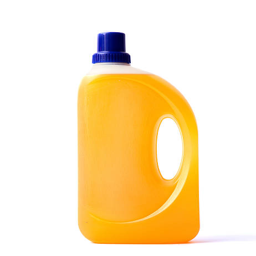


───────── PREDICTIONS ─────────
environmental_score_grade : a
main_category_en          : rapeseed oils
nutriscore_grade          : b
packaging_en              : bottle, plastic
labels_en                 : —


In [8]:
from pathlib import Path
import pickle, torch, torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
from IPython.display import display

# ---------------- Paths ---------------- #
MODEL_DIR  = Path("/kaggle/input/greenchoicemodel1/pytorch/default/1")
IMG_SIZE   = 224
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- Load model & encoders ---------------- #
with open(MODEL_DIR / "encoders.pkl", "rb") as f:
    enc_data = pickle.load(f)
label_encoders    = enc_data["label_encoders"]
multi_encoders    = enc_data["multi_encoders"]
SINGLE_LABEL_COLS = enc_data["SINGLE_LABEL_COLS"]
MULTI_LABEL_COLS  = enc_data["MULTI_LABEL_COLS"]

# ---------------- Model Definition ---------------- #
class Head(nn.Module):
    def __init__(self, in_f, out_f): super().__init__(); self.fc = nn.Linear(in_f, out_f)
    def forward(self, x): return self.fc(x)

class MultiTask(nn.Module):
    def __init__(self, n_single, n_multi):
        super().__init__()
        b = models.efficientnet_b0(weights=None)
        in_f = b.classifier[1].in_features
        b.classifier = nn.Identity()
        self.backbone = b
        self.heads = nn.ModuleDict({k: Head(in_f, n)
                                    for k, n in {**n_single, **n_multi}.items()})
    def forward(self, x):
        f = self.backbone(x)
        return {k: h(f) for k, h in self.heads.items()}

n_single = {c: len(label_encoders[c].classes_) for c in SINGLE_LABEL_COLS}
n_multi  = {c: len(multi_encoders[c].classes_) for c in MULTI_LABEL_COLS}

model = MultiTask(n_single, n_multi).to(DEVICE)
model.load_state_dict(torch.load(MODEL_DIR / "best_model.pt", map_location=DEVICE))
model.eval()
print("✓ model ready")

# ---------------- Transform ---------------- #
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# ---------------- Set Threshold ---------------- #
THRESHOLD = 0.3  # Only show multi-labels with score > threshold

# ---------------- Choose Image ---------------- #
TEST_IMG = Path("/kaggle/input/testimage/product in plastic.jpg")  # <== Your image here
assert TEST_IMG.is_file(), f"Image not found: {TEST_IMG}"
display(Image.open(TEST_IMG).resize((256,256)))

# ---------------- Predict ---------------- #
img = tfm(Image.open(TEST_IMG).convert("RGB")).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    outs = model(img)

# ---------------- Decode & Pretty Print ---------------- #
print("\n───────── PREDICTIONS ─────────")
for col in SINGLE_LABEL_COLS:
    idx = outs[col].argmax(1).item()
    label = label_encoders[col].classes_[idx]
    print(f"{col:<26}: {label}")

for col in MULTI_LABEL_COLS:
    scores = outs[col].sigmoid().squeeze(0).cpu().numpy()
    mlb    = multi_encoders[col]
    chosen = [cls for cls, s in zip(mlb.classes_, scores) if s > THRESHOLD]
    print(f"{col:<26}: {', '.join(chosen) if chosen else '—'}")


✓ model ready


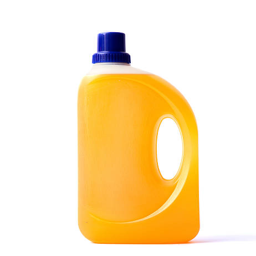


───────── PREDICTIONS ─────────
environmental_score_grade : a
main_category_en          : rapeseed oils
nutriscore_grade          : b
packaging_en              : bottle, plastic
labels_en                 : —
🌍 No greener alternative found with matching labels.


In [11]:
from pathlib import Path
import pickle, torch, torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
import pandas as pd
from IPython.display import display, Image as IPImage

# ---------------- Paths ---------------- #
MODEL_DIR  = Path("/kaggle/input/greenchoicemodel1/pytorch/default/1")
CSV_PATH   = Path("/kaggle/input/greenchoicedata/df_filtered_unique_complete_qtygrams.csv")
IMG_SIZE   = 224
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
THRESHOLD  = 0.3

# ---------------- Load model & encoders ---------------- #
with open(MODEL_DIR / "encoders.pkl", "rb") as f:
    enc_data = pickle.load(f)
label_encoders    = enc_data["label_encoders"]
multi_encoders    = enc_data["multi_encoders"]
SINGLE_LABEL_COLS = enc_data["SINGLE_LABEL_COLS"]
MULTI_LABEL_COLS  = enc_data["MULTI_LABEL_COLS"]

# ---------------- Model Definition ---------------- #
class Head(nn.Module):
    def __init__(self, in_f, out_f): super().__init__(); self.fc = nn.Linear(in_f, out_f)
    def forward(self, x): return self.fc(x)

class MultiTask(nn.Module):
    def __init__(self, n_single, n_multi):
        super().__init__()
        b = models.efficientnet_b0(weights=None)
        in_f = b.classifier[1].in_features
        b.classifier = nn.Identity()
        self.backbone = b
        self.heads = nn.ModuleDict({k: Head(in_f, n)
                                    for k, n in {**n_single, **n_multi}.items()})
    def forward(self, x):
        f = self.backbone(x)
        return {k: h(f) for k, h in self.heads.items()}

n_single = {c: len(label_encoders[c].classes_) for c in SINGLE_LABEL_COLS}
n_multi  = {c: len(multi_encoders[c].classes_) for c in MULTI_LABEL_COLS}

model = MultiTask(n_single, n_multi).to(DEVICE)
model.load_state_dict(torch.load(MODEL_DIR / "best_model.pt", map_location=DEVICE))
model.eval()
print("✓ model ready")

# ---------------- Load catalog ---------------- #
catalog_df = pd.read_csv(CSV_PATH)

# Normalize grades
def norm_grade(g):
    g = str(g).strip().lower().replace("+", "plus").replace(" ", "-")
    return g if g in {"a-plus", "a", "b", "c", "d", "e", "f"} else None

grade_rank = {
    "a-plus": 6,
    "a": 5,
    "b": 4,
    "c": 3,
    "d": 2,
    "e": 1,
    "f": 0
}

catalog_df["environmental_score_grade"] = catalog_df["environmental_score_grade"].apply(norm_grade)
catalog_df = catalog_df.dropna(subset=["environmental_score_grade", "main_category_en"])
catalog_df["env_rank"] = catalog_df["environmental_score_grade"].map(grade_rank)

# ---------------- Transform ---------------- #
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# ---------------- Prediction + Decoding ---------------- #
def predict(img_path):
    img = Image.open(img_path).convert("RGB")
    display(img.resize((256,256)))

    x = tfm(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        outs = model(x)

    pred = {}
    # Single label decoding
    for col in SINGLE_LABEL_COLS:
        idx = outs[col].argmax(1).item()
        pred[col] = label_encoders[col].classes_[idx]

    # Multi label decoding
    for col in MULTI_LABEL_COLS:
        scores = outs[col].sigmoid().squeeze(0).cpu().numpy()
        mlb = multi_encoders[col]
        chosen = [cls for cls, s in zip(mlb.classes_, scores) if s > THRESHOLD]
        pred[col] = chosen if chosen else []

    print("\n───────── PREDICTIONS ─────────")
    for k, v in pred.items():
        if isinstance(v, list):
            print(f"{k:<26}: {', '.join(v) if v else '—'}")
        else:
            print(f"{k:<26}: {v}")

    return pred

# ---------------- Greener Alternative Recommendation ---------------- #

def show_greener_alternative(pred: dict, catalog=catalog_df):
    cat = pred.get("main_category_en")
    curg = norm_grade(pred.get("environmental_score_grade"))
    cur_labels = set(pred.get("labels_en", []))  # multi-label

    if not cat or not curg:
        print("⚠️ Missing or unrecognized category or grade.")
        return
    
    cur_rank = grade_rank.get(curg)
    if cur_rank is None:
        print("⚠️ Grade not in ranking scale.")
        return

    # Filter catalog by category, better env rank, and overlapping labels
    # Require at least one label to match (you can tighten this logic if you want)
    def labels_match(row_labels):
        if pd.isna(row_labels) or row_labels.strip() == "":
            return False
        row_set = set([l.strip() for l in row_labels.split(",")])
        return len(cur_labels.intersection(row_set)) > 0

    candidates = catalog[
        (catalog["main_category_en"] == cat) &
        (catalog["env_rank"] > cur_rank) &
        catalog["labels_en"].apply(labels_match)
    ]

    if candidates.empty:
        print("🌍 No greener alternative found with matching labels.")
        return

    # Sort candidates to pick best overall greener alternative
    candidates = candidates.sort_values(
        by=["env_rank", "nutriscore_grade", "quantity_in_grams"],
        ascending=[False, True, True]
    ).iloc[0]

    print("\n🟢 Greener Alternative Found:")
    print(f"Brand       : {candidates.get('brands_en', '—')}")
    print(f"Eco Score   : {candidates.get('environmental_score_grade', '—')}")
    print(f"Nutri-Score : {candidates.get('nutriscore_grade', '—')}")
    print(f"Packaging   : {candidates.get('packaging_en', '—')}")
    print(f"Labels      : {candidates.get('labels_en', '—')}")

    if pd.notna(candidates.get("image_url", "")):
        display(IPImage(url=candidates["image_url"], width=200))


# ---------------- Run Everything ---------------- #

TEST_IMG = Path("/kaggle/input/testimage/product in plastic.jpg")  # Change this path

predicted = predict(TEST_IMG)
show_greener_alternative(predicted)
